In [ ]:
# Install PyTorch
!pip3 install torch torchvision
!pip3 install scvi-tools
!pip3 install scanpy
!pip3 install scArches
!pip3 install matplotlib==3.1.3

In [ ]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import scarches as sca
%matplotlib inline

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Research/PhD/SCANVI/')

In [ ]:
import time

# Run on Abbas et al

In [ ]:
# Default settings from scArches guide
condition_key = 'Patient'
cell_type_key = 'Cluster'

vae_epochs = 500
scanvi_epochs = 200
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [ ]:
### Reference Training

# Load adata
AMLcat = sc.read_h5ad("Data/Fig3_Relapse_Deconvolution/pvg_AbbasA_AMLcat.h5ad")
AMLcat.obs.Cluster = np.where(AMLcat.obs.Cluster=='nan', 'Unknown', AMLcat.obs.Cluster)
AMLcat.obs = AMLcat.obs.rename(columns={'CellType':'CellType_SCN'})
ref_data = AMLcat[(AMLcat.obs['Cohort'] == "vanGalen")]
query_data = AMLcat[(AMLcat.obs['Cohort'] != "vanGalen")]

del(AMLcat)
# Top 3000 highly variable genes for classification
sc.pp.highly_variable_genes(ref_data, batch_key='Patient', n_top_genes=3000)
ref_data = ref_data[:, ref_data.var.highly_variable]
ref_data

In [ ]:
ref_data = sca.dataset.setup_anndata(ref_data, layer='counts', batch_key=condition_key, labels_key=cell_type_key, copy=True)

In [ ]:
vae = sca.models.SCANVI(
    ref_data,
    "Unknown",
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
    use_cuda=True
)

In [ ]:
vae.train(
    n_epochs_unsupervised=vae_epochs,
    n_epochs_semisupervised=scanvi_epochs,
    unsupervised_trainer_kwargs=dict(early_stopping_kwargs=early_stopping_kwargs),
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["elbo", "accuracy"],
                                       early_stopping_kwargs=early_stopping_kwargs_scanvi),
    frequency=1
)

In [ ]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_type"] = ref_data.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = ref_data.obs[condition_key].tolist()

In [ ]:
sc.pp.neighbors(reference_latent, n_neighbors=10)
sc.tl.umap(reference_latent, min_dist=0.5)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
reference_latent.obs['predictions'] = vae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

In [ ]:
ref_path = 'Data/Fig3_Relapse_Deconvolution/scArches_models/ref_model/'
vae.save(ref_path, overwrite=True)

## Run Query

In [ ]:
ref_path = 'Data/Fig3_Relapse_Deconvolution/scArches_models/ref_model/'
HVGs = ref_data.var_names

In [ ]:
query_data.X = query_data.layers['counts']

In [ ]:
query_data = query_data[:,HVGs]
query_data.obs[cell_type_key] = vae.unlabeled_category_

Trying to set attribute `.obs` of view, copying.


In [ ]:
?sca.models.SCANVI.load_query_data

In [ ]:
model = sca.models.SCANVI.load_query_data(
    query_data,
    ref_path,
    freeze_dropout = True,
    use_cuda=True
)
model._unlabeled_indices = np.arange(query_data.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 22200 cells, 3000 vars, 20        
         batches, 8 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
Labelled Indices:  0
Unlabelled Indices:  22200


In [ ]:
model.train(
    n_epochs_semisupervised=surgery_epochs,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"],
                                       weight_decay=0,
                                       early_stopping_kwargs=early_stopping_kwargs_surgery
                                      ),
    frequency=1
)


INFO     Training Unsupervised Trainer for 360 epochs.                                       
INFO     Training SemiSupervised Trainer for 500 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  47%|████▋     | 235/500 [23:02<25:49,  5.85s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0.001 nats in 10 epochs                 
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  47%|████▋     | 235/500 [23:08<26:05,  5.91s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  499 

In [ ]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = query_data.obs[cell_type_key].tolist()
query_latent.obs['batch'] = query_data.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 432x288 with 0 Axes>

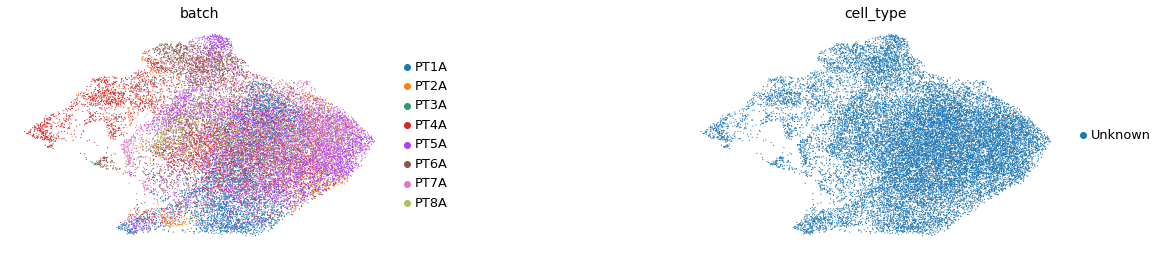

In [ ]:
sc.pp.neighbors(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

In [ ]:
surgery_path = 'Data/Fig3_Relapse_Deconvolution/scArches_models/surgery_model'
model.save(surgery_path, overwrite=True)

## Concatenate

In [ ]:
adata_full = ref_data.concatenate(query_data)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_full.obs[condition_key].tolist()

In [ ]:
full_latent.obs['Cohort'] = np.where(full_latent.obs['batch'].str.contains('AML'), 'vanGalen', 'Abbas')

<Figure size 432x288 with 0 Axes>

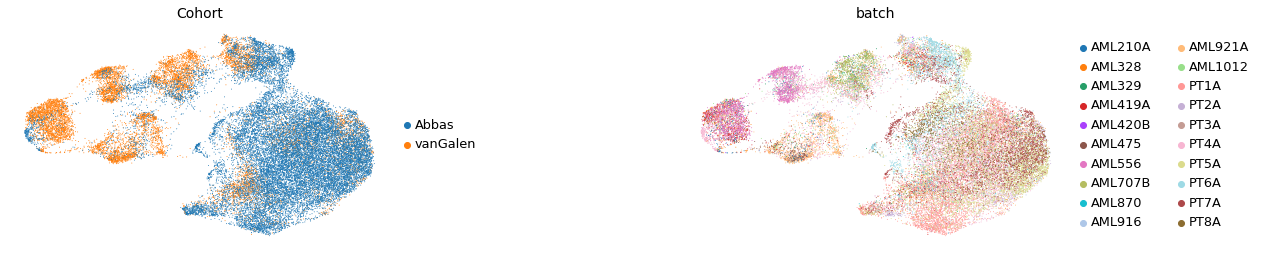

In [ ]:
sc.pp.neighbors(full_latent, n_neighbors=30)
sc.tl.umap(full_latent, min_dist=0.2)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["Cohort", "batch"],
    frameon=False,
    wspace=0.6,
)

In [ ]:
full_latent.obs['UMAP1'] = full_latent.obsm['X_umap'][:,0]
full_latent.obs['UMAP2'] = full_latent.obsm['X_umap'][:,1]

In [ ]:
full_latent.obsm['X_umap'][:,0] = -full_latent.obs['UMAP1']
full_latent.obsm['X_umap'][:,1] = full_latent.obs['UMAP2']

In [ ]:
full_latent.obs['predictions'] = full_latent.obs['predictions'].cat.set_categories(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])
full_latent.obs['Diagnostic AML (van Galen et al)'] = full_latent.obs['predictions']
full_latent.obs['Relapsed AML (Abbas et al)'] = full_latent.obs['predictions']
full_latent.obs['CellType'] = full_latent.obs['predictions']
full_latent.obs['Patient'] = full_latent.obs['batch']

In [ ]:
full_latent.obs.index = adata_full.obs.index

In [ ]:
full_latent.write_h5ad('Data/Fig3_Relapse_Deconvolution/combined_PVG_Abbas_scArches.h5ad')

### Checkpoint

In [ ]:
full_latent = sc.read_h5ad('Data/Fig3_Relapse_Deconvolution/combined_PVG_Abbas_scArches.h5ad')

In [ ]:
abbas = full_latent[full_latent.obs.Cohort=='Abbas']
sc.pp.subsample(abbas, n_obs=10000)
vanGalen = full_latent[full_latent.obs.Cohort=='vanGalen']
sc.pp.subsample(vanGalen, n_obs=10000)
new_latent = abbas.concatenate(vanGalen)
new_latent

AnnData object with n_obs × n_vars = 20000 × 10
    obs: 'cell_type', 'batch', 'predictions', 'Cohort', 'UMAP1', 'UMAP2', 'Diagnostic AML (van Galen et al)', 'Relapsed AML (Abbas et al)', 'Patient', 'CellType'
    obsm: 'X_umap'

In [ ]:
sc.pp.neighbors(new_latent, n_neighbors=30)

In [ ]:
sc.tl.umap(new_latent, min_dist=0.2)

In [ ]:
new_latent.obs['UMAP1'] = new_latent.obsm['X_umap'][:,0]
new_latent.obs['UMAP2'] = new_latent.obsm['X_umap'][:,1]

In [ ]:
new_latent.obsm['X_umap'][:,0] = -new_latent.obs['UMAP1']
new_latent.obsm['X_umap'][:,1] = new_latent.obs['UMAP2']

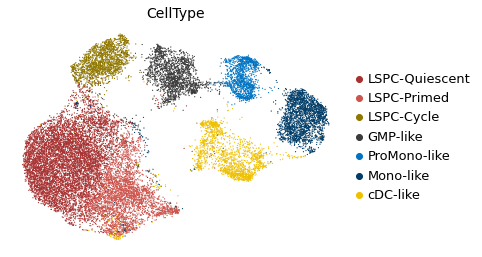

In [ ]:
sc.pl.umap(
    new_latent,
    color=["CellType"],
    frameon=False,
    wspace=0.6,
    palette=['#A7303099', '#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099'], 
)

Trying to set attribute `.uns` of view, copying.


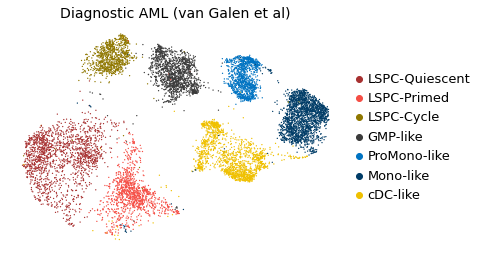

In [ ]:
sc.pl.umap(
    new_latent[new_latent.obs["Cohort"] == "vanGalen"],
    size=7,
    color="Diagnostic AML (van Galen et al)",
    palette=['#A73030', '#f54e45', '#8F7700', '#3B3B3B', '#0073C2', '#003C67', '#EFC000'],
    frameon=False,
    save = '_Combined_vanGalen_Abbas_CellType_Diagnostic_10k.png' 
)

Trying to set attribute `.uns` of view, copying.


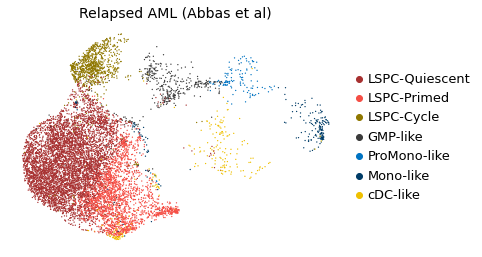

In [ ]:
sc.pl.umap(
    new_latent[new_latent.obs["Cohort"] == "Abbas"],
    size=7,
    color="Relapsed AML (Abbas et al)",
    palette=['#A73030', '#f54e45', '#8F7700', '#3B3B3B', '#0073C2', '#003C67', '#EFC000'],
    frameon=False,
    save = '_Combined_vanGalen_Abbas_CellType_Relapse_10k.png' 
)

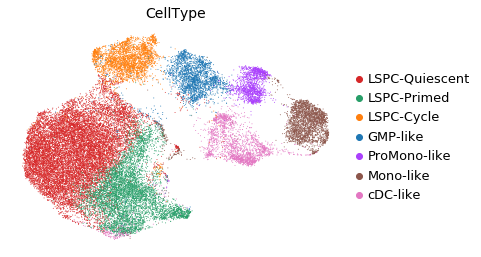

In [ ]:
sc.pl.umap(
    full_latent,
    color=["CellType"],
    frameon=False,
    wspace=0.6,
    palette=['C3', 'C2', 'C1', 'C0', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'], 
    save = '_Combined_vanGalen_Abbas_CellType.png'
)

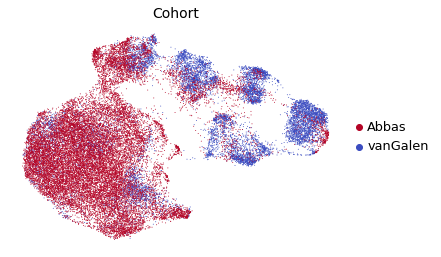

In [ ]:
sc.pl.umap(
    full_latent,
    color=["Cohort"],
    frameon=False,
    wspace=0.6,
    palette='coolwarm_r',
    save = '_Combined_vanGalen_Abbas_Cohort.png'
)

Trying to set attribute `.uns` of view, copying.


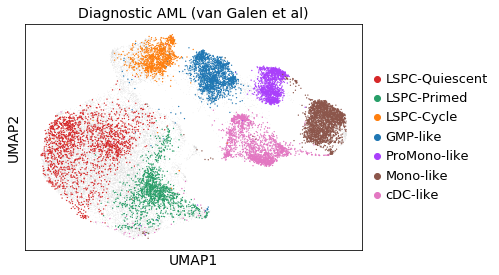

In [ ]:
ax = sc.pl.umap(full_latent, size=1, show=False)
sc.pl.umap(
    full_latent[full_latent.obs["Cohort"] == "vanGalen"],
    size=7,
    color="Diagnostic AML (van Galen et al)",
    ax=ax,
    palette=['C3', 'C2', 'C1', 'C0', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'],
    save = '_Combined_vanGalen_Abbas_CellType_Diagnostic.png' 
)

Trying to set attribute `.uns` of view, copying.


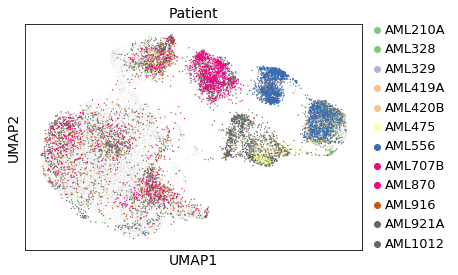

In [ ]:
ax = sc.pl.umap(full_latent, size=1, show=False)
sc.pl.umap(
    full_latent[full_latent.obs["Cohort"] == "vanGalen"],
    size=7,
    color="Patient",
    ax=ax,
    palette='Accent',
    save = '_Combined_vanGalen_Abbas_Patient_Diagnostic.png' 
)

Trying to set attribute `.uns` of view, copying.


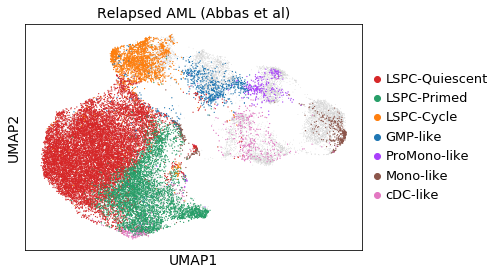

In [ ]:
ax = sc.pl.umap(full_latent, size=2, show=False)
sc.pl.umap(
    full_latent[full_latent.obs["Cohort"] == "Abbas"],
    size=6,
    color="Relapsed AML (Abbas et al)",
    ax=ax,
    palette=['C3', 'C2', 'C1', 'C0', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'], 
    save = '_Combined_vanGalen_Abbas_CellType_Relapsed.png' 
)

Trying to set attribute `.uns` of view, copying.


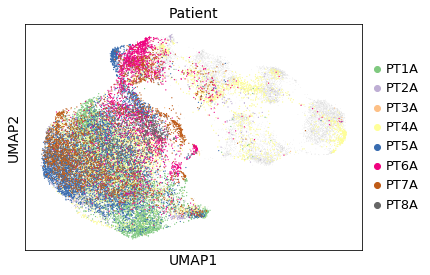

In [ ]:
ax = sc.pl.umap(full_latent, size=1, show=False)
sc.pl.umap(
    full_latent[full_latent.obs["Cohort"] == "Abbas"],
    size=6,
    color="Patient",
    ax=ax,
    palette='Accent',
    save = '_Combined_vanGalen_Abbas_Patient_Relapsed.png' 
)

In [ ]:
full_latent.obs[['Patient', 'Cohort', 'UMAP1', 'UMAP2', 'CellType']].to_csv("Data/Fig3_Relapse_Deconvolution/scArches_PVG_Abbas_CellType_Classified.csv", index_label='Cell')